# Finding regions under selection

## [paper title]


breif description

In [41]:
import scipy.stats
import statsmodels.api as sm
import statsmodels as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import allel
import shutil
import math
import yaml
import pandas as pd
from intervaltree import IntervalTree
from collections import defaultdict
from scipy import stats
from scipy import signal

os.chdir("/master/nplatt/sch_man_nwinvasion")

Calculate the cumulative length fo each chromosome for downstream plotting

In [31]:
#make sure that all stops are not gt chrom length
chr_length = {}
#genome_size = 0
with open('/master/nplatt/sch_man_nwinvasion/data/genomes/Smansoni_v7.fa.fai', 'r') as fai:
    for entry in fai:
        chrom, length, *offset = entry.rstrip().split("\t")
        chr_length[chrom]=int(length)

    cumul_start={}
    cumul_start['SM_V7_1']=0
    cumul_start['SM_V7_2']= cumul_start['SM_V7_1'] + chr_length['SM_V7_1']
    cumul_start['SM_V7_3']= cumul_start['SM_V7_2'] + chr_length['SM_V7_2']
    cumul_start['SM_V7_4']= cumul_start['SM_V7_3'] + chr_length['SM_V7_3']
    cumul_start['SM_V7_5']= cumul_start['SM_V7_4'] + chr_length['SM_V7_4']
    cumul_start['SM_V7_6']= cumul_start['SM_V7_5'] + chr_length['SM_V7_5']
    cumul_start['SM_V7_7']= cumul_start['SM_V7_6'] + chr_length['SM_V7_6']
    scanned_size = cumul_start['SM_V7_7'] + chr_length['SM_V7_7']

# msprime 

breif description

In [35]:
%%bash

mkdir -p results/msprime/logs

CONDA="conda activate sch_man_nwinvasion-msprime;"
QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 1 "    

for POP in tanzania senegal niger brazil; do
    mkdir results/msprime/$POP
    for I in $(seq 1 100); do
        MSPRIME_CMD="python code/msprime-qsub.py $POP $I"       
        echo "$CONDA $MSPRIME_CMD" | $QSUB -N $POP"_"$I -o results/msprime/logs/$POP"_"$I.log
    done
done


#--------------------------------------------------------------------------------------------------------
# msprime-qsub.py
#--------------------------------------------------------------------------------------------------------

# import msprime
# import os
# import subprocess
# import sys
# from random import randint

# pop = sys.argv[1]
# iteration = sys.argv[2]

# #################################
# def sim_tree(iteration, pop, length, recomb_rate, mut_rate, seed):
    
#     tree_sequence = msprime.simulate( sample_size=n_samples[pop], 
#         Ne=ne[pop], 
#         length=88.9e6, 
#         recombination_rate=3.4e-8,
#         mutation_rate=8.1e-9,
#         random_seed=seed)

#     print("iter {}: {} completed".format(iteration, pop))
#     #print(tree.draw(format="unicode"))

#     with open("results/msprime/{}/chr1_{}_rep_{}_seed_{}.vcf".format(pop, pop, iteration, seed), "w") as vcf_file:
#         tree_sequence.write_vcf(vcf_file, ploidy=2)
# ########################################

# #calcualted by est_pop_params.py
# ne = { "brazil"      : 18293,
#        "niger"       : 19971,
#        "senegal"     : 22421,
#        "tanzania"    : 52234 }

# n_samples = { "brazil"   : 48*2,
#               "senegal"  : 25*2,
#               "niger"    : 10*2,
#               "tanzania" : 58*2  }

# seed = randint(0,1e6)
# sim_tree(iteration, pop, 88e-9, 3.4e-8, 8.1e-9, seed)

Your job 5672368 ("tanzania_1") has been submitted
Your job 5672369 ("tanzania_2") has been submitted
Your job 5672370 ("tanzania_3") has been submitted
Your job 5672371 ("tanzania_4") has been submitted
Your job 5672372 ("tanzania_5") has been submitted
Your job 5672373 ("tanzania_6") has been submitted
Your job 5672374 ("tanzania_7") has been submitted
Your job 5672375 ("tanzania_8") has been submitted
Your job 5672376 ("tanzania_9") has been submitted
Your job 5672377 ("tanzania_10") has been submitted
Your job 5672378 ("tanzania_11") has been submitted
Your job 5672379 ("tanzania_12") has been submitted
Your job 5672380 ("tanzania_13") has been submitted
Your job 5672381 ("tanzania_14") has been submitted
Your job 5672382 ("tanzania_15") has been submitted
Your job 5672383 ("tanzania_16") has been submitted
Your job 5672384 ("tanzania_17") has been submitted
Your job 5672385 ("tanzania_18") has been submitted
Your job 5672386 ("tanzania_19") has been submitted
Your job 5672387 ("ta

Now after all the jobs have finished the through the scheudler take each simulated chrom and extract only the snps that fall within exome-probed regions

In [ ]:
#--------------------------------------------------------------------------------------------------------
# msprime-probe_snps_from_vcf.py
#--------------------------------------------------------------------------------------------------------

import msprime
import os
import subprocess
import glob


#now create bed for the new "sim" chr1
with open('data/renamed-sma_agilent_baits.v7.0.chr_reorderd.bed', 'r') as in_bed:
    with open('results/msprime/sim_probes.bed', 'w') as out_bed:
        for bed_entry in in_bed:
            chrom, start, stop = bed_entry.rstrip().split("\t")
            if chrom == "SM_V7_1":
                out_bed.write("1\t{}\t{}\n".format(start, stop))

bed = 'results/msprime/sim_probes.bed'
#now loop through all of the sim vcf files to get snps at probed regions
for pop in ["niger", "senegal", "tanzania", "brazil"]:
    out_dir = "results/msprime/{}".format(pop)
    
    sim_vcfs = glob.glob("{}/chr1_*_rep_*.vcf".format(out_dir))
    for sim_vcf in sim_vcfs:

        probed_vcf = sim_vcf.replace(".vcf", "_probed.vcf")         
        jid = "probe_{}".format(probed_vcf.split("/")[-1])
        log = "{}/logs".format(out_dir)

        vcf_cmd = "vcftools --vcf {} --bed {} --recode --recode-INFO-all --stdout >{}".format(sim_vcf, bed, probed_vcf)
        qsub_cmd =  "qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 3 -N {} -o {}".format(jid, log)
        conda_cmd = "conda activate sch_man_nwinvasion-msprime"

        cmd ="echo \"{}; {}\" | {}".format(conda_cmd, vcf_cmd, qsub_cmd)

        #run vcf cmd
        #process = subprocess.Popen(cmd.split(""),
        #                     stdout=subprocess.PIPE, 
        #                     stderr=subprocess.PIPE)
        !{cmd}

# H-scan

HSCAN identifies regions under selection based on the length of haplotypes.  (citation).  We used a custom code to convert HSCAN to VCF input formats.

Run on actual data with:
```code/hscan-run_with_real_data.sh```

Repeat the process on simulated data:

```code/hscan-run_with_sim_data.sh```

Once those analyses are finished come back here to process the results

In [38]:
#% bash

#code/hscan-run_with_real_data.sh
#code/hscan-run_with_sim_data.sh

## Combine runs, smooth H, and generate a .csv file

In [28]:
#SET WINDOW SMOOTHING SIZE HERE
window=201

In [29]:
#cycle through each population to calculate generate csv file with H scores, etc. 
for pop in ["niger", "senegal", "brazil", "tanzania"]:

    print(pop)

    #make sure lists are clean
    chrom_s=[]
    pos_s=[]
    h_s=[]
    smoothed_h_s=np.array([])

    #read all the hscan output for the population into lists for chrom, h, and pos
    for i in range(1,8):
        tmp_chr_h_s=[]

        chrom = "SM_V7_{}".format(i)
        
        with open("results/hscan/{}/{}_{}.hscan-out".format(pop, chrom, pop), 'r') as hscan_file:
            #skip the header line
            next(hscan_file)
            
            for calc in hscan_file:
                
                pos, h = calc.rstrip().split("\t")
                
                chrom_s.append(chrom)
                tmp_chr_h_s.append(h)
                h_s.append(h)
                pos_s.append(pos)

        #smooth the h_s for this chromosome and add to an array
        smoothed_h=scipy.signal.medfilt(np.array(tmp_chr_h_s).astype(float), window)
        smoothed_h_s=np.append(smoothed_h_s, smoothed_h)

    #convert the lists to numpy arrays
    chrom_s=np.array(chrom_s)
    pos_s=np.array(pos_s)
    h_s=np.array(h_s).astype(np.float)
    
    #now add all info to a data table
    columns = ["chrom", "pos", "h", "smoothed_h"]
    df = pd.DataFrame(data = [chrom_s, pos_s, h_s, smoothed_h_s]).T
    df.columns=columns

    #get cumulative positions along the genome (additive positions; used to easily organize data in chr order)
    fig_x_pos_s=[]
    for index, row in df.iterrows(): 
        fig_x_pos_s.append(int(row["pos"]) + int(cumul_start[row['chrom']]))

    df['fig_x_pos']=fig_x_pos_s
    df = df.sort_values(["fig_x_pos"], ascending = True)

    #save data to csv file
    csv_file ="results/hscan/{}_hscan.csv".format(pop)
    df.to_csv(csv_file, index=False, header=True, mode='w')


niger
senegal
brazil
tanzania


# Sweepfinder2


Run Sweepfinder2 on actual data (preps files, calculates pop-specific SFS, then runs Sweepfinder2:

```code/sweepfinder2-run_with_real_data.sh```

Repeat the process on simulated data:

```code/sweepfinder2-run_with_sim_data.sh```

Once those analyses are finished come back here to process the results

In [39]:
#% bash

#code/sweepfinder2-run_with_real_data.sh
#code/sweepfinder2_sim_data.sh

## Combine runs and generate a .csv file


In [37]:
#cycle through each population to calculate generate csv file with H scores, pvalues etc. 
for pop in ["niger", "senegal", "brazil", "tanzania"]:
    print(pop)
    
    #make sure lists are clean
    chrom_s=[]
    pos_s=[]
    lr_s=[]

    #read all the sweepfinder output for the population into lists for chrom, lr, and pos
    for i in range(1,8):
        chrom = "SM_V7_{}".format(i)
        
        with open("results/sweepfinder/{}/{}_{}.sf2out".format(pop, chrom, pop), 'r') as sf2_file:
            #skip header line
            next(sf2_file)
            for calc in sf2_file:
                
                pos, lr, alpha = calc.rstrip().split("\t")
                
                chrom_s.append(chrom)
                lr_s.append(lr)
                pos_s.append(pos)

    #convert the lists to numpy arrays
    chrom_s=np.array(chrom_s)
    pos_s=np.array(pos_s)
    lr_s=np.array(lr_s).astype(np.float)
    
    #now add all info to a data table
    columns = ["chrom", "pos", "lr"]
    df = pd.DataFrame(data = [chrom_s, pos_s, lr_s]).T
    df.columns=columns

    #get cumulative positions along the genome (additive positions; used to easily organize data in chr order)
    fig_x_pos_s=[]
    for index, row in df.iterrows(): 
        fig_x_pos_s.append(int(float(row["pos"])) + int(cumul_start[row['chrom']]))

    df['fig_x_pos']=fig_x_pos_s
    df = df.sort_values(["fig_x_pos"], ascending = True)

    #save data to csv file
    csv_file ="results/sweepfinder/{}_sf2.csv".format(pop)
    df.to_csv(csv_file, index=False, header=True, mode='w')

niger
senegal
brazil
tanzania


# Reconcile SF2 and HSCAN stats per window/site

In [50]:
if not os.path.exists("results/selection_peaks"):
    os.mkdir("results/selection_peaks")
  

for pop in ["senegal", "niger", "brazil", "tanzania"]:
    print(pop)

    #designate files
    hscan_file = "results/hscan/{}_hscan.csv".format(pop)
    sweep_file = "results/sweepfinder/{}/{}_sf2.csv".format(pop, pop)

    #read in to dfs    
    hscan_df = pd.read_csv(hscan_file, sep=",")
    sweep_df = pd.read_csv(sweep_file, sep=",")

    #merge data frames
    df = hscan_df

    for chrom in range(1,8):
        chrom="SM_V7_{}".format(chrom)

        chrom_df       = df.loc[df['chrom'] == chrom]     
        chrom_sweep_df = sweep_df.loc[sweep_df['chrom'] == chrom]     
       
    #build interval tree of all sweepfinder values
    sweep_trees=defaultdict(lambda: IntervalTree()) 
    for index, row in sweep_df.iterrows():
        sweep_trees[row.chrom][row.pos:row.pos+1001] = row.lr

    lrs=[]
    for index, row in df.iterrows():
        lr = sorted(sweep_trees[row.chrom].at(row.pos))[0].data   
        lrs.append(lr)
    
    #add sweepfinder values to dataframe
    df["lr"]=lrs
    
    #GET PERCENTILES XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    df["lr_perc_rank"]  = df["lr"].rank(pct=True)
    df["h_perc_rank"]   = df["h"].rank(pct=True)
    df["smoothed_h_perc_rank"]   = df["smoothed_h"].rank(pct=True)

    
    #subsample dataframe for desired values
    df = df[["chrom", "pos", "h", "h_perc_rank", "smoothed_h", "smoothed_h_perc_rank", "lr", "lr_perc_rank", "fig_x_pos"]]

    #get complete records
    df = df.dropna()

    #save as new csv for dcms
    csv_file = "./results/selection_peaks/{}_raw_data.csv".format(pop)
    df = df.sort_values(["fig_x_pos"], ascending = True)
    df.to_csv(csv_file, index=False, header=True, mode='w')

senegal
niger
brazil
tanzania


# Find "peaks of interest"

Search through all of the MSPRIME iterations for each population to find the maximum values of H and LR (used to identify the reasonable expectations of these values from neutral evolution)

In [6]:
import glob
from collections import defaultdict

#get highest simluated score for each pop/test

max_h = defaultdict(lambda: float(0))
max_lr = defaultdict(lambda: float(0))
    
for pop in ["senegal", "niger", "tanzania", "brazil"]:
    
    sim_hscan_files = glob.glob("results/hscan/{}-msprime/chr1_{}_rep_*_seed_*_probed.vcf.hscan-out".format(pop, pop))
    sim_sf2_files = glob.glob("results/sweepfinder/{}-sim/chr1_{}_rep_*_seed_*_probed.sw2out".format(pop, pop))

    for hscan_file in sim_hscan_files:
        with open(hscan_file, 'r') as infile:
            next(infile)
            for entry in infile:
                x, h = entry.rstrip().split("\t")
                if float(h) > max_h[pop]:
                    max_h[pop]=float(h)

    for sf2_file in sim_sf2_files:
        with open(sf2_file, 'r') as infile:
            next(infile)
            for entry in infile:
                location, lr, alpha = entry.rstrip().split("\t")
                if float(lr) > max_lr[pop]:
                    max_lr[pop]=float(lr)
    
    outline="{} h_max={} lr_max={}".format(pop, max_h[pop], max_lr[pop])
    print(outline)

senegal h_max=38426.4 lr_max=17.397502
niger h_max=27040.7 lr_max=15.94272
tanzania h_max=45532.9 lr_max=16.871399
brazil h_max=43924.1 lr_max=15.387932


Here we are finding sites in the H and LR data that meet a certain threshold. 


In [7]:
target_percentile=0.99

In [ ]:
#now find sites with hscan, sweepfinder, and fst in the top X% (as long as all scores gt sim)

for pop in ["senegal", "niger", "brazil", "tanzania"]:
    #print(pop)
    sig_hits=0
    highest_h=0
    highest_lr=0
    csv_file = "./results/selection_peaks/{}_raw_data.csv".format(pop)

    with open(csv_file, 'r') as infile:
        
        bed_file = "./results/selection_peaks/{}_sig_snps.bed".format(pop)
        with open(bed_file, 'w') as outfile:
            next(infile)
            for entry in infile:
                chrom,pos,h,h_perc_rank,smoothed_h,smoothed_h_perc_rank,fst,fst_perc_rank,lr,lr_perc_rank,fig_x_pos_x = entry.rstrip().split(",")

                if ((float(smoothed_h_perc_rank)   >target_percentile) and 
                    (float(lr_perc_rank)  >target_percentile) and
                    (float(h) > max_h[pop])     and 
                    (float(lr) > max_lr[pop] )):

                    sig_bed_entry="{}\t{}\t{}\n".format(chrom, pos, str(int(pos)+1))
                    outfile.write(sig_bed_entry)

## Plot Hscan and Sweepfinder data

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from intervaltree import IntervalTree

#make sure that all stops are not gt chrom length
chr_length = {}
#genome_size = 0
with open('data/genomes/Smansoni_v7.fa.fai', 'r') as fai:
    for entry in fai:
        chrom, length, *offset = entry.rstrip().split("\t")
        chr_length[chrom]=int(length)

cumul_start={}
cumul_start['SM_V7_1']=0
cumul_start['SM_V7_2']= cumul_start['SM_V7_1'] + chr_length['SM_V7_1']
cumul_start['SM_V7_3']= cumul_start['SM_V7_2'] + chr_length['SM_V7_2']
cumul_start['SM_V7_4']= cumul_start['SM_V7_3'] + chr_length['SM_V7_3']
cumul_start['SM_V7_5']= cumul_start['SM_V7_4'] + chr_length['SM_V7_4']
cumul_start['SM_V7_6']= cumul_start['SM_V7_5'] + chr_length['SM_V7_5']
cumul_start['SM_V7_7']= cumul_start['SM_V7_6'] + chr_length['SM_V7_6']
scanned_size = cumul_start['SM_V7_7'] + chr_length['SM_V7_7']

def get_x_pos(chrom, pos):
    x_pos=pos+cumul_start[chrom]
    return x_pos

#set plot colors
sig_color = "red"

def get_chrom_color (row):
    if row['chrom'] in ("SM_V7_1", "SM_V7_3", "SM_V7_5", "SM_V7_7"):
        return 'silver'
    if row['chrom'] in ("SM_V7_2", "SM_V7_4", "SM_V7_6" ):
        return 'black'
    

#define tick locations
ticks = [ (cumul_start['SM_V7_1'] + cumul_start['SM_V7_2'] )/2,
          (cumul_start['SM_V7_2'] + cumul_start['SM_V7_3'] )/2,
          (cumul_start['SM_V7_3'] + cumul_start['SM_V7_4'] )/2,
          (cumul_start['SM_V7_4'] + cumul_start['SM_V7_5'] )/2,
          (cumul_start['SM_V7_5'] + cumul_start['SM_V7_6'] )/2,
          (cumul_start['SM_V7_6'] + cumul_start['SM_V7_7'] )/2,
          (cumul_start['SM_V7_7'] + scanned_size )/2 ]

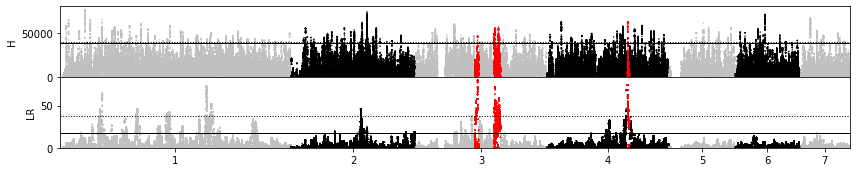

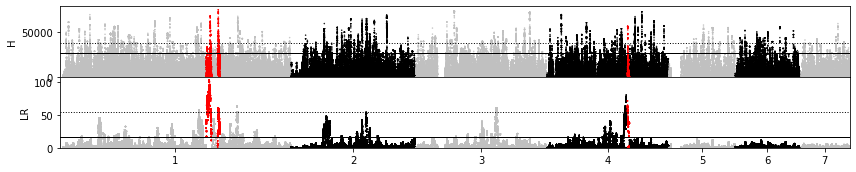

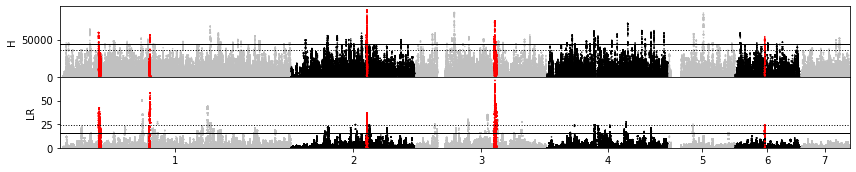

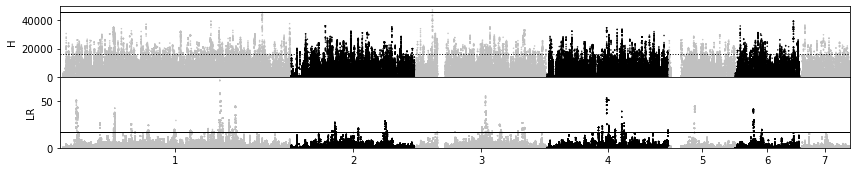

In [33]:
buffer=1_000_00

if os.path.exists("results/selection_peaks/peaks.bed"):
    os.remove("results/selection_peaks/peaks.bed")
    
for pop in ["senegal", "niger", "brazil", "tanzania"]:
#for pop in ["brazil"]:

    csv_file = "./results/selection_peaks/{}_raw_data.csv".format(pop)
    df=pd.read_csv(csv_file, sep=",")
    
    ##########################################################################
    #get points that meet the significance threshold
    percentile = 0.99
    non_neutral_df = df.loc[(df['h']> max_h[pop]) | (df['lr']> max_lr[pop]) ]
 
    buffered_non_neutral_peaks=defaultdict(lambda: IntervalTree()) 

    for index, row in non_neutral_df.iterrows():
        buf_begin=row["pos"]-buffer
        buf_end=row["pos"]+buffer
        buffered_non_neutral_peaks[row["chrom"]][buf_begin: buf_end ] = "sig"

    #merge
    for chrom in buffered_non_neutral_peaks.keys():
        buffered_non_neutral_peaks[chrom].merge_overlaps()

    #intersect these peaks wtih 99%ers
    sig_snp_peaks_df = df.loc[(df['h_perc_rank']> percentile) & 
                              (df['lr_perc_rank']> percentile) & 
                              (df['h']> max_h[pop]) & 
                              (df['lr']> max_lr[pop]) ]

    sig_snp_peaks=defaultdict(lambda: IntervalTree()) 
    for index, row in sig_snp_peaks_df.iterrows():
        sig_snp_peaks[row["chrom"]][row["pos"]: row["pos"]+1]="sig"

    #union
    peak_tree =defaultdict(lambda: IntervalTree()) 
    for index, row in sig_snp_peaks_df.iterrows():
        for interval in buffered_non_neutral_peaks[row["chrom"]].at(row["pos"]):
            peak_tree[row["chrom"]].add(interval)
    
    #subtract buffer
    final_peak_tree =defaultdict(lambda: IntervalTree()) 
    for chrom in peak_tree.keys():
        for interval in peak_tree[chrom]:
            unbuf_start=interval.begin+buffer
            unbuf_end=interval.end-buffer
            final_peak_tree[chrom][unbuf_start: unbuf_end]="sig"

    #save peaks for downstream
    with open('results/selection_peaks/peaks.bed', 'a') as bed:
        for chrom in final_peak_tree.keys():
            for interval in final_peak_tree[chrom]:
                bed_entry="{}\t{}\t{}\t{}\n".format(chrom, interval.begin, interval.end, pop)
                bed.write(bed_entry)

    #now that all of the peaks are defined, we color all snps (wether they meet the sig threhold or not)
    df["color"]="black"
    for index, row in df.iterrows():
        if final_peak_tree[row["chrom"]].at(row["pos"]):
            df.at[index, "color"]= sig_color
        else:
            #chrom_color=get_chrom_color(row)
            df.at[index, "color"]=get_chrom_color(row)
           
    #plot log data for H
    tick_lbls = [ "1", "2", "3", "4", "5", "6" ,"7"]

    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(12, 2.5))
    
    insig_df=df.loc[df.color != sig_color]
    sig_df=df.loc[df.color == sig_color]

    axs[0].scatter(insig_df["fig_x_pos_x"], insig_df['h'], marker =".", s = 1, c = insig_df["color"]) 
    axs[0].scatter(sig_df["fig_x_pos_x"],   sig_df['h'],   marker =".", s = 1, c = sig_df["color"]) 
    axs[1].scatter(insig_df["fig_x_pos_x"], insig_df['lr'],         marker =".", s = 1, c = insig_df["color"]) 
    axs[1].scatter(sig_df["fig_x_pos_x"],   sig_df['lr'],           marker =".", s = 1, c = sig_df["color"]) 

    #set axes
    axs[0].set_xlim((0,scanned_size))
    axs[0].set_ylim((0,max(np.append(df['h'], max_h[pop])*1.05)))
    axs[1].set_ylim((0,max(np.append(df['lr'], max_lr[pop])*1.05)))
                    
    plt.setp(axs, xticks=ticks, xticklabels=tick_lbls)
    axs[0].set(ylabel="H")
    axs[1].set(ylabel="LR")
    axs[0].ticklabel_format(axis='y', style='sci')

    #draw lines at...
    #...the max simulated value
    axs[0].axhline(y=max_h[pop],  color="black", linewidth=1)
    axs[1].axhline(y=max_lr[pop], color="black", linewidth=1)

    #...the 99th percentile
    axs[0].axhline(y=np.percentile(df['smoothed_h'],  percentile*100), linestyle=":",  color="black", linewidth=1)
    axs[1].axhline(y=np.percentile(df['lr'], percentile*100), linestyle=":", color="black", linewidth=1)
    
    #set the title
    #title="{}".format(pop.title())
    #fig.suptitle(title)

    #plt.text(df['fig_x_pos'][-1:], -np.log10(2.056684e-05), 'FDR=0.01', horizontalalignment='right')

    plt.tight_layout()
    fig.savefig("results/selection_peaks/{}_selection_slim_rawh.png".format(pop), dpi=300) 
    plt.show()
    plt.close()

In [34]:
!cat results/selection_peaks/peaks.bed

SM_V7_3	31533655	32970509	senegal
SM_V7_3	30306048	31252999	senegal
SM_V7_3	22786583	24333624	senegal
SM_V7_4	31216154	32022278	senegal
SM_V7_1	60735396	61618309	niger
SM_V7_1	56295674	58355355	niger
SM_V7_4	31216154	31930596	niger
SM_V7_1	34234733	34811638	brazil
SM_V7_1	14832351	15772978	brazil
SM_V7_2	29221592	29604554	brazil
SM_V7_3	30307643	31252999	brazil
SM_V7_6	11468141	11631926	brazil


# Unused

## FST

In [5]:


os.chdir("/master/nplatt/sch_man_nwinvasion")

if not os.path.exists("results/fst_per_window"):
    os.mkdir("results/fst_per_window")
    
with open('data/pop_assign.yml') as yaml_file:
    pop_assign = yaml.load(yaml_file, Loader=yaml.FullLoader)

#-----------------------------------
# get lengths from cumul positions
#make sure that all stops are not gt chrom length
chr_length = {}
#genome_size = 0
with open('/master/nplatt/sch_man_nwinvasion/data/genomes/Smansoni_v7.fa.fai', 'r') as fai:
    for entry in fai:
        chrom, length, *offset = entry.rstrip().split("\t")
        chr_length[chrom]=int(length)

    cumul_start={}
    cumul_start['SM_V7_1']=0
    cumul_start['SM_V7_2']= cumul_start['SM_V7_1'] + chr_length['SM_V7_1']
    cumul_start['SM_V7_3']= cumul_start['SM_V7_2'] + chr_length['SM_V7_2']
    cumul_start['SM_V7_4']= cumul_start['SM_V7_3'] + chr_length['SM_V7_3']
    cumul_start['SM_V7_5']= cumul_start['SM_V7_4'] + chr_length['SM_V7_4']
    cumul_start['SM_V7_6']= cumul_start['SM_V7_5'] + chr_length['SM_V7_5']
    cumul_start['SM_V7_7']= cumul_start['SM_V7_6'] + chr_length['SM_V7_6']
    scanned_size = cumul_start['SM_V7_7'] + chr_length['SM_V7_7']

#-------------------------------------------------------------------------------
# get genotype info per population

#read in vcf
callset=allel.read_vcf('results/variant_filtration/smv7_ex_autosomes.vcf')

#now get an index for each sample/population
samples = callset["samples"]

i=0 
pop_idxs = defaultdict(list)   
for sample in samples:  
     pop_idxs[pop_assign[sample]].append(i) 
     i=i+1 

pops= list(pop_idxs.keys()) 

#get genotypes
gt=allel.GenotypeArray(callset['calldata/GT'])

#now get allele count per population
ac=gt.count_alleles()

#for simplicity add maf info to callset data
maf=ac[:, :2].min(axis=1)/ac[:, :2].sum(axis=1)
callset['maf']=maf 

pop_ac={}
for pop in pops:
    pop_ac[pop] = gt.count_alleles(subpop=pop_idxs[pop])
    
#-------------------------------------------------------------------------------
#generate windows
window=100_000

#define an array of window start and stops
window_starts = [int(x - (window/2)) for x in callset['variants/POS']]
window_stops  = [int(x + (window/2)) for x in callset['variants/POS']]

#make sure that window starts are all gt 1
window_starts = [1 if i < 1 else i for i in window_starts]


#make sure that all stops are not gt chrom length
chr_length = {}
#genome_size = 0
with open('/master/nplatt/sch_man_nwinvasion/data/genomes/Smansoni_v7.fa.fai', 'r') as fai:
    for entry in fai:
        chrom, length, *offset = entry.rstrip().split("\t")
        chr_length[chrom]=int(length)
        #genome_size = genome_size + chr_length[chrom]
    
i=0
for stop in window_stops:
    chrom = callset['variants/CHROM'][i]
    
    if stop > chr_length[chrom]:
        window_stops[i]=chr_length[chrom]
    i=i+1
    
windows = np.column_stack((np.array(window_starts), 
                           np.array(window_stops)))

callset['windows']=windows

In [209]:
#-------------------------------------------------------------------------------
# fst calculations

pops = ["brazil", "tanzania", "niger", "senegal" ]

idx_comps = {"brazil":   [pop_idxs["brazil"],   pop_idxs["tanzania"] + pop_idxs["niger"]  + pop_idxs["senegal"] ],
             "tanzania": [pop_idxs["tanzania"], pop_idxs["brazil"]   + pop_idxs["niger"]  + pop_idxs["senegal"] ],
             "niger":    [pop_idxs["niger"],    pop_idxs["tanzania"] + pop_idxs["brazil"] + pop_idxs["senegal"] ],
             "senegal":  [pop_idxs["senegal"],  pop_idxs["tanzania"] + pop_idxs["niger"]  + pop_idxs["brazil"] ]}

#make comparisons between population
for pop in idx_comps.keys():
    print(pop)
    pop1_idx = idx_comps[pop][0]
    pop2_idx = idx_comps[pop][1]

    fst_s             = []
    fst_calc_window_s = []
    fst_count_s       = []

    #create empty dataframe to store data    
    headers = ["chrom", "pos", "fst", "smoothed_fst", "window", "num_snps", "zscore", "pvalue", "-log10(p)"]
    df=pd.DataFrame(columns=headers) 

    #now loop through each chromosome
    for chrom in list(set(callset['variants/CHROM'])) :
        target_sites = np.logical_and( callset['maf'] < 0.05, 
                                       callset['variants/CHROM'] == chrom )  

        chr_gts  = gt[target_sites]
        chr_poss = callset['variants/POS'][target_sites]
        chr_wins = callset['windows'][target_sites]

        
        fsts, fst_calc_windows, fst_counts =allel.windowed_weir_cockerham_fst(chr_poss, chr_gts, subpops=[pop1_idx, pop2_idx], windows=chr_wins )

        #get rid of nan values
        useful_values = np.logical_and( np.isfinite(fsts), fst_counts>=10) 

        fsts = fsts[useful_values]
        fst_calc_windows = fst_calc_windows[useful_values]
        fst_counts = fst_counts[useful_values]
        chr_poss = chr_poss[useful_values]

        #set negative fst values to 0
        i=0
        for fst in fsts:
            if fst <0:
                fsts[i]=0
            i=i+1        
        
        #smooth
        smoothed_fsts=signal.medfilt(fsts, kernel_size = 101)

        #add data to dataframe/table
        data = list(zip([chrom]*len(fsts), chr_poss, fsts, smoothed_fsts, fst_calc_windows, fst_counts))
        chr_df=pd.DataFrame(data, columns=headers)
        df = df.append(chr_df)

    #add cumul positions
    fig_x_pos_s=[]
    for index, row in df.iterrows(): 
        fig_x_pos_s.append(int(row["pos"]) + int(cumul_start[row['chrom']]))

    df['fig_x_pos']=fig_x_pos_s

    #save data to csv file
    csv_file = "./results/fst_per_window/{}_vs_all_windowed_fst.csv".format(pop)
    df = df.sort_values(["fig_x_pos"], ascending = True)
    df.to_csv(csv_file, index=False, header=True, mode='w')

NameError: name 'pop_idxs' is not defined

## other

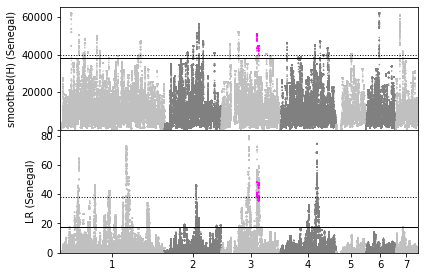

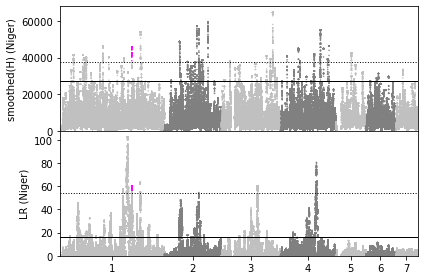

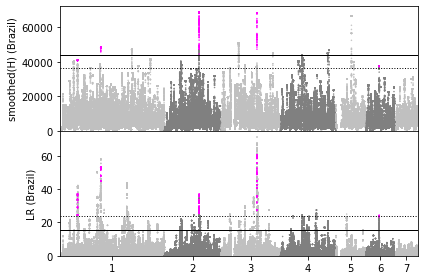

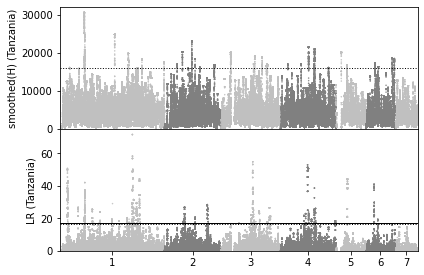

In [791]:
for pop in ["senegal", "niger", "brazil", "tanzania"]:
#for pop in ["senegal"]:

    csv_file = "./results/selection_peaks/{}_raw_data.csv".format(pop)
    df=pd.read_csv(csv_file, sep=",")
    
    ##########################################################################
    #get points that meet the significance threshold
    percentile = 0.99
    sig_df = df.loc[(df['smoothed_h_perc_rank']> percentile) & (df['lr_perc_rank']> percentile) & (df['h']> max_h[pop]) & (df['lr']> max_lr[pop])]
   
    #individual points need to be merged (i.e. points that overlap or are within 1Mb of each other)
    sig_snp_trees=defaultdict(lambda: IntervalTree()) 
    buffer=1_00_00

    #to start, go through all of the snps that meet the significance threshold and add them to an
    # interval tree with 1Mb on both sides (as a buffer)
    for index, row in sig_df.iterrows():
        sig_snp_trees[row.chrom][row.pos-buffer: row.pos+buffer+1 ] = "sig"

    #now go through each intervaltree (chromosome) and combine overlapping snps (+buffer)
    for chrom in sig_snp_trees.keys():
        sig_snp_trees[chrom].merge_overlaps()

    #to define the peaks we need to extract the merged/overlapping regions and remove the buffer 
    peaks=defaultdict(lambda: IntervalTree()) 

    #...so for each intervaltree/chrom
    for chrom in sig_snp_trees.keys():
        #...and each "peak" (merged region)
        for interval in sig_snp_trees[chrom]:
           #remove the buffer
            begin=interval.begin+buffer
            end=interval.end-buffer

            #and add the final region to the "peaks" interval tree
            peaks[chrom][begin:end]="sig"

    ##########################################################################
    #now we need to find all "non-neutral snps"        
    non_neutral_trees=defaultdict(lambda: IntervalTree()) 
    non_neutral_df   =df.loc[ (df["smoothed_h"]>max_h[pop]) | (df["lr"]>max_lr[pop]) ]

    for index, row in non_neutral_df.iterrows():
        non_neutral_trees[row.chrom][row.pos-buffer: row.pos+buffer+1 ] = "non_neutral"

    non_neutral_peaks=defaultdict(lambda: IntervalTree()) 

    #...so for each intervaltree/chrom
    for chrom in non_neutral_trees.keys():
        non_neutral_trees[chrom].merge_overlaps()
        #...and each "peak" (merged region)
        for interval in non_neutral_trees[chrom]:
           #remove the buffer
            begin=interval.begin+buffer
            end=interval.end-buffer

            #and add the final region to the "peaks" interval tree
            non_neutral_peaks[chrom][begin:end]="non-neutral"       

    ##########################################################################
    peaks_of_selection=defaultdict(lambda: IntervalTree()) 

    for chrom in peaks.keys():
        buffer_tree=IntervalTree()
        #combine all peaks
        union_tree = non_neutral_peaks[chrom] | peaks[chrom]
        #add buffer to each
        for interval in union_tree:
        #add the buffer
            begin=interval.begin-buffer
            end=interval.end+buffer
            buffer_tree[begin:end]="buffer"

        #merge
        buffer_tree.merge_overlaps()

        #get any peaks from the actual peak tree
        for interval in peaks[chrom]:
            #print(buffer_tree[interval.begin:interval.end])
            peaks_of_selection[chrom][interval.begin:interval.end]="peak"
    #..........................................................................
        
    #now that all of the peaks are defined, we color all snps (wether they meet the sig threhold or not)
    df["color"]="black"
    for index, row in df.iterrows():
        if peaks_of_selection[row["chrom"]].at(row["pos"]):
           # if ( row["h"]> max_h[pop] )
        #if (peaks[row["chrom"]].at(row["pos"])) or (non_neutral_peaks[row["chrom"]].at(row["pos"])): 
        #        if ( peaks[row["chrom"]].at(row["pos"]) ) #and ( row["h"]> max_h[pop] ) and ( row["lr"]> max_lr[pop] ):
            df.at[index, "color"]= sig_color
        else:
            #chrom_color=get_chrom_color(row)
            df.at[index, "color"]=get_chrom_color(row)
           
    #plot log data for H
    tick_lbls = [ "1", "2", "3", "4", "5", "6" ,"7"]

    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
    
    insig_df=df.loc[df.color != sig_color]
    sig_df=df.loc[df.color == sig_color]

    axs[0].scatter(insig_df["fig_x_pos_x"], insig_df['smoothed_h'], marker =".", s = 1, c = insig_df["color"]) 
    axs[0].scatter(sig_df["fig_x_pos_x"],   sig_df['smoothed_h'],   marker =".", s = 1, c = sig_df["color"]) 
    axs[1].scatter(insig_df["fig_x_pos_x"], insig_df['lr'],         marker =".", s = 1, c = insig_df["color"]) 
    axs[1].scatter(sig_df["fig_x_pos_x"],   sig_df['lr'],           marker =".", s = 1, c = sig_df["color"]) 

    #set axes
    axs[0].set_xlim((0,scanned_size))
    axs[0].set_ylim((0,max(df['smoothed_h']*1.05)))
    axs[1].set_ylim((0,max(df['lr']*1.05)))
                    
    plt.setp(axs, xticks=ticks, xticklabels=tick_lbls)
    axs[0].set(ylabel="smoothed(H) ({})".format(pop.title()))
    axs[1].set(ylabel="LR ({})".format(pop.title()))
    axs[0].ticklabel_format(axis='y', style='sci')

    #draw lines at...
    #...the max simulated value
    axs[0].axhline(y=max_h[pop],  color="black", linewidth=1)
    axs[1].axhline(y=max_lr[pop], color="black", linewidth=1)

    #...the 99th percentile
    axs[0].axhline(y=np.percentile(df['smoothed_h'],  percentile*100), linestyle=":",  color="black", linewidth=1)
    axs[1].axhline(y=np.percentile(df['lr'], percentile*100), linestyle=":", color="black", linewidth=1)
    
    #set the title
    #title="{}".format(pop.title())
    #fig.suptitle(title)

    #plt.text(df['fig_x_pos'][-1:], -np.log10(2.056684e-05), 'FDR=0.01', horizontalalignment='right')

    plt.tight_layout()
    fig.savefig("results/selection_peaks/{}_selection.png".format(pop), dpi=300) 
    plt.show()
    plt.close()

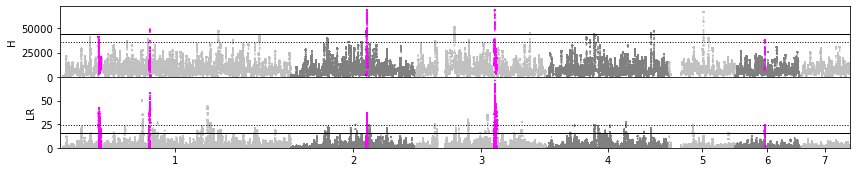

In [835]:
buffer=1_000_00

#for pop in ["senegal", "niger", "brazil", "tanzania"]:
for pop in ["brazil"]:

    csv_file = "./results/selection_peaks/{}_raw_data.csv".format(pop)
    df=pd.read_csv(csv_file, sep=",")
    
    ##########################################################################
    #get points that meet the significance threshold
    percentile = 0.99
    non_neutral_df = df.loc[(df['h']> max_h[pop]) | (df['lr']> max_lr[pop]) ]
 
    buffered_non_neutral_peaks=defaultdict(lambda: IntervalTree()) 

    for index, row in non_neutral_df.iterrows():
        buf_begin=row["pos"]-buffer
        buf_end=row["pos"]+buffer
        buffered_non_neutral_peaks[row["chrom"]][buf_begin: buf_end ] = "sig"

    #merge
    for chrom in buffered_snp_trees.keys():
        buffered_non_neutral_peaks[chrom].merge_overlaps()

    #intersect these peaks wtih 99%ers
    sig_snp_peaks_df = df.loc[(df['smoothed_h_perc_rank']> percentile) & 
                              (df['lr_perc_rank']> percentile) & 
                              (df['h']> max_h[pop]) & 
                              (df['lr']> max_lr[pop]) ]

    sig_snp_peaks=defaultdict(lambda: IntervalTree()) 
    for index, row in sig_snp_peaks_df.iterrows():
        sig_snp_peaks[row["chrom"]][row["pos"]: row["pos"]+1]="sig"

    #union
    peak_tree =defaultdict(lambda: IntervalTree()) 
    for index, row in sig_snp_peaks_df.iterrows():
        for interval in buffered_non_neutral_peaks[row["chrom"]].at(row["pos"]):
            peak_tree[row["chrom"]].add(interval)
    
    #subtract buffer
    final_peak_tree =defaultdict(lambda: IntervalTree()) 
    for chrom in peak_tree.keys():
        for interval in peak_tree[chrom]:
            unbuf_start=interval.begin+buffer
            unbuf_end=interval.end-buffer
            final_peak_tree[chrom][unbuf_start: unbuf_end]="sig"
    
    #now that all of the peaks are defined, we color all snps (wether they meet the sig threhold or not)
    df["color"]="black"
    for index, row in df.iterrows():
        if final_peak_tree[row["chrom"]].at(row["pos"]):
            df.at[index, "color"]= sig_color
        else:
            #chrom_color=get_chrom_color(row)
            df.at[index, "color"]=get_chrom_color(row)
           
    #plot log data for H
    tick_lbls = [ "1", "2", "3", "4", "5", "6" ,"7"]

    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(12, 2.5))
    
    insig_df=df.loc[df.color != sig_color]
    sig_df=df.loc[df.color == sig_color]

    axs[0].scatter(insig_df["fig_x_pos_x"], insig_df['smoothed_h'], marker =".", s = 1, c = insig_df["color"]) 
    axs[0].scatter(sig_df["fig_x_pos_x"],   sig_df['smoothed_h'],   marker =".", s = 1, c = sig_df["color"]) 
    axs[1].scatter(insig_df["fig_x_pos_x"], insig_df['lr'],         marker =".", s = 1, c = insig_df["color"]) 
    axs[1].scatter(sig_df["fig_x_pos_x"],   sig_df['lr'],           marker =".", s = 1, c = sig_df["color"]) 

    #set axes
    axs[0].set_xlim((0,scanned_size))
    axs[0].set_ylim((0,max(np.append(df['smoothed_h'], max_h[pop])*1.05)))
    axs[1].set_ylim((0,max(np.append(df['lr'], max_lr[pop])*1.05)))
                    
    plt.setp(axs, xticks=ticks, xticklabels=tick_lbls)
    axs[0].set(ylabel="H")
    axs[1].set(ylabel="LR")
    ax.set_xlabel('{}'.format(pop.title()))
    axs[0].ticklabel_format(axis='y', style='sci')

    #draw lines at...
    #...the max simulated value
    axs[0].axhline(y=max_h[pop],  color="black", linewidth=1)
    axs[1].axhline(y=max_lr[pop], color="black", linewidth=1)

    #...the 99th percentile
    axs[0].axhline(y=np.percentile(df['smoothed_h'],  percentile*100), linestyle=":",  color="black", linewidth=1)
    axs[1].axhline(y=np.percentile(df['lr'], percentile*100), linestyle=":", color="black", linewidth=1)
    
    #set the title
    #title="{}".format(pop.title())
    #fig.suptitle(title)

    #plt.text(df['fig_x_pos'][-1:], -np.log10(2.056684e-05), 'FDR=0.01', horizontalalignment='right')

    plt.tight_layout()
    fig.savefig("results/selection_peaks/{}_selection_slim.png".format(pop), dpi=300) 
    plt.show()
    plt.close()